# <a id='toc1_'></a>[Deep Learning MC](#toc0_)

Arian Iseni

**Table of contents**<a id='toc0_'></a>    
- [Deep Learning MC](#toc1_)    
- [Dataset](#toc2_)    
    - [What do the class names present?](#toc2_1_1_)    
  - [Human-readable mapping](#toc2_2_)    
  - [Data splitting](#toc2_3_)    
  - [Displaying Images](#toc2_4_)    
  - [Image shape](#toc2_5_)    
  - [RGB Distribution](#toc2_6_)    
- [Setup for experimentation](#toc3_)    
  - [Seed](#toc3_1_)    
  - [Trainer](#toc3_2_)    
  - [Baseline Model](#toc3_3_)    
  - [Image Preprocessing Strategies](#toc3_4_)    
    - [Load data with ImageFolder](#toc3_4_1_)    
    - [Small Training for image preprocessing](#toc3_4_2_)    
      - [Model init](#toc3_4_2_1_)    
      - [Resize test run](#toc3_4_2_2_)    
      - [Center crop run](#toc3_4_2_3_)    
      - [Wandb plots](#toc3_4_2_4_)    
    - [Cross Validation](#toc3_4_3_)    
      - [Resize test](#toc3_4_3_1_)    
      - [Center crop test](#toc3_4_3_2_)    
        - [Cross Validation overview](#toc3_4_3_2_1_)    
  - [Overfit Test](#toc3_5_)    
    - [Interpretation](#toc3_5_1_)    
  - [Baseline Test](#toc3_6_)    
    - [Baseline interpretation](#toc3_6_1_)    
      - [Conclusion](#toc3_6_1_1_)    
- [Hyperparameter Tests](#toc4_)    
  - [Learning Rate Test](#toc4_1_)    
    - [Interpretation](#toc4_1_1_)    
  - [Batchsize Test](#toc4_2_)    
    - [Reflexion](#toc4_2_1_)    
      - [Interesting](#toc4_2_1_1_)    
  - [Weight Test](#toc4_3_)    
    - [Interpretation](#toc4_3_1_)    
  - [Number of FC-Layers](#toc4_4_)    
    - [Reflexion](#toc4_4_1_)    
      - [Insight](#toc4_4_1_1_)    
  - [Convolutional Layers](#toc4_5_)    
    - [Interpretation](#toc4_5_1_)    
      - [Insight:](#toc4_5_1_1_)    
  - [Filter Test](#toc4_6_)    
    - [Memory Error](#toc4_6_1_)    
    - [Hypothesis confirmed, but with nuances:](#toc4_6_2_)    
  - [Kernel Sizes](#toc4_7_)    
    - [Interpretation](#toc4_7_1_)    
  - [Dropout Test](#toc4_8_)    
    - [Interpretation](#toc4_8_1_)    
  - [Batchnorm](#toc4_9_)    
    - [Interpretation](#toc4_9_1_)    
      - [Insight](#toc4_9_1_1_)    
  - [Adam Optimizer](#toc4_10_)    
    - [Interpretation](#toc4_10_1_)    
  - [Data Augmentation](#toc4_11_)    
    - [Interpretation](#toc4_11_1_)    
  - [Best Model](#toc4_12_)    
- [Transfer Learning](#toc5_)    
  - [Transfer Learning with ResNet18 (Fine-Tuning)](#toc5_1_)    
    - [Reflexion about ResNet18](#toc5_1_1_)    
      - [Conclusion: When transfer learning makes sense](#toc5_1_1_1_)    
  - [Conclusion three models](#toc5_2_)    
- [Insights and Reflection](#toc6_)    
  - [Final Conclusion](#toc6_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import os
import sys

notebook_path = os.path.abspath(".")
project_root = os.path.abspath(os.path.join(notebook_path, ".."))
os.chdir(project_root)

sys.path.append(os.path.join(project_root, "src"))

print(f"Current working directory: {project_root}")

%env WANDB_SILENT=true
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

Current working directory: /home/arian/deepLearning/del
env: WANDB_SILENT=true
env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
import random
import shutil
import pickle
from glob import glob
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from tqdm import tqdm
from tqdm.notebook import tqdm as notebook_tqdm

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy

import wandb

from src.utils import plot_training_curves

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
import numpy as np
import pickle
import os
import hashlib

torch.use_deterministic_algorithms(True)

# <a id='toc2_'></a>[Dataset](#toc0_)

Since there isn't any direct description what the dataset contains, which I downloaded here [Kaggle](https://www.kaggle.com/datasets/liusha249/imagenet10), I will first try to get an overview about my dataset.

In [71]:
data_dir = os.path.join(project_root, "data", "original")

class_names = sorted(os.listdir(data_dir))
print(f"Count of classes: {len(class_names)}")
print(f"Example class names: {class_names}")

Count of classes: 10
Example class names: ['n02056570', 'n02085936', 'n02128757', 'n02690373', 'n02692877', 'n03095699', 'n04254680', 'n04285008', 'n04467665', 'n07747607']


### <a id='toc2_1_1_'></a>[What do the class names present?](#toc0_)

Those `n02056570` are so called `WNDIs` which are WordNet IDs - unique identifiers used by ImageNet to represent a specific synset (i.e., a group of synonymous words/meanings). Those aren't at all not human-readable, even if they map to actual objects.

To make training in the future easier, I will map these IDs to human-readable labels:

## <a id='toc2_2_'></a>[Human-readable mapping](#toc0_)

In [4]:
wnid_to_label = {
    "n02056570": "King Penguin",
    "n02085936": "Maltese dog",
    "n02128757": "Snow Leopard",
    "n02690373": "Airliner",
    "n02692877": "Airship",
    "n03095699": "Container ship",
    "n04254680": "Soccer ball",
    "n04285008": "Sports car",
    "n04467665": "Trailer truck",
    "n07747607": "Orange (fruit)"
}

In [6]:
# Rename folders in data_dir from WNID to human-readable label
for wnid, label in wnid_to_label.items():
    old_path = os.path.join(data_dir, wnid)
    new_path = os.path.join(data_dir, label)
    if os.path.exists(old_path) and not os.path.exists(new_path):
        os.rename(old_path, new_path)

# Update class_names after renaming
class_names = sorted(os.listdir(data_dir))
print(f"Renamed class folders. New class names: {class_names}")

Renamed class folders. New class names: ['Airliner', 'Airship', 'Container ship', 'King Penguin', 'Maltese dog', 'Orange (fruit)', 'Snow Leopard', 'Soccer ball', 'Sports car', 'Trailer truck']


Let's dive deeper into the dataset. Now we will see how many images there are and how many per class.

In [ ]:
image_counts = {}
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    num_images = len(os.listdir(class_path))
    image_counts[class_name] = num_images

print("Number of images per class:")
total_images = 0
for class_name, count in image_counts.items():
    print(f"{class_name}: {count}")
    total_images += count
print(f"Total number of images: {total_images}")

Number of images per class:
Airliner: 1300
Airship: 1300
Container ship: 1300
King Penguin: 1300
Maltese dog: 1300
Orange (fruit): 1300
Snow Leopard: 1300
Soccer ball: 1300
Sports car: 1300
Trailer truck: 1300
Total number of images: 13000


## <a id='toc2_3_'></a>[Data splitting](#toc0_)

In [8]:
original_dir = os.path.join(project_root, "data", "original")
split_base_dir = os.path.join(project_root, "data", "split_data")

train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "val")
test_dir = os.path.join(split_base_dir, "test")

# Delete target directories and recreate them
for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

# Split-Ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

class_names = sorted(os.listdir(original_dir))

for class_name in class_names:
    img_dir = os.path.join(original_dir, class_name)
    all_images = glob(os.path.join(img_dir, "*.JPEG"))
    print(f"Class '{class_name}' has {len(all_images)} images before split.")

    train_imgs, temp_imgs = train_test_split(all_images, train_size=train_ratio, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)  # each 10%

    print(f"  Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    for split, img_list in zip(
        [train_dir, val_dir, test_dir],
        [train_imgs, val_imgs, test_imgs]
    ):
        target_class_dir = os.path.join(split, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        for img in img_list:
            shutil.copy(img, os.path.join(target_class_dir, os.path.basename(img)))

print("Train/Val/Test split completed.")

Class 'Airliner' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Airship' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Container ship' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'King Penguin' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Maltese dog' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Orange (fruit)' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Snow Leopard' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Soccer ball' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Sports car' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Class 'Trailer truck' has 1300 images before split.
  Train: 1040, Val: 130, Test: 130
Train/Val/Test split completed.


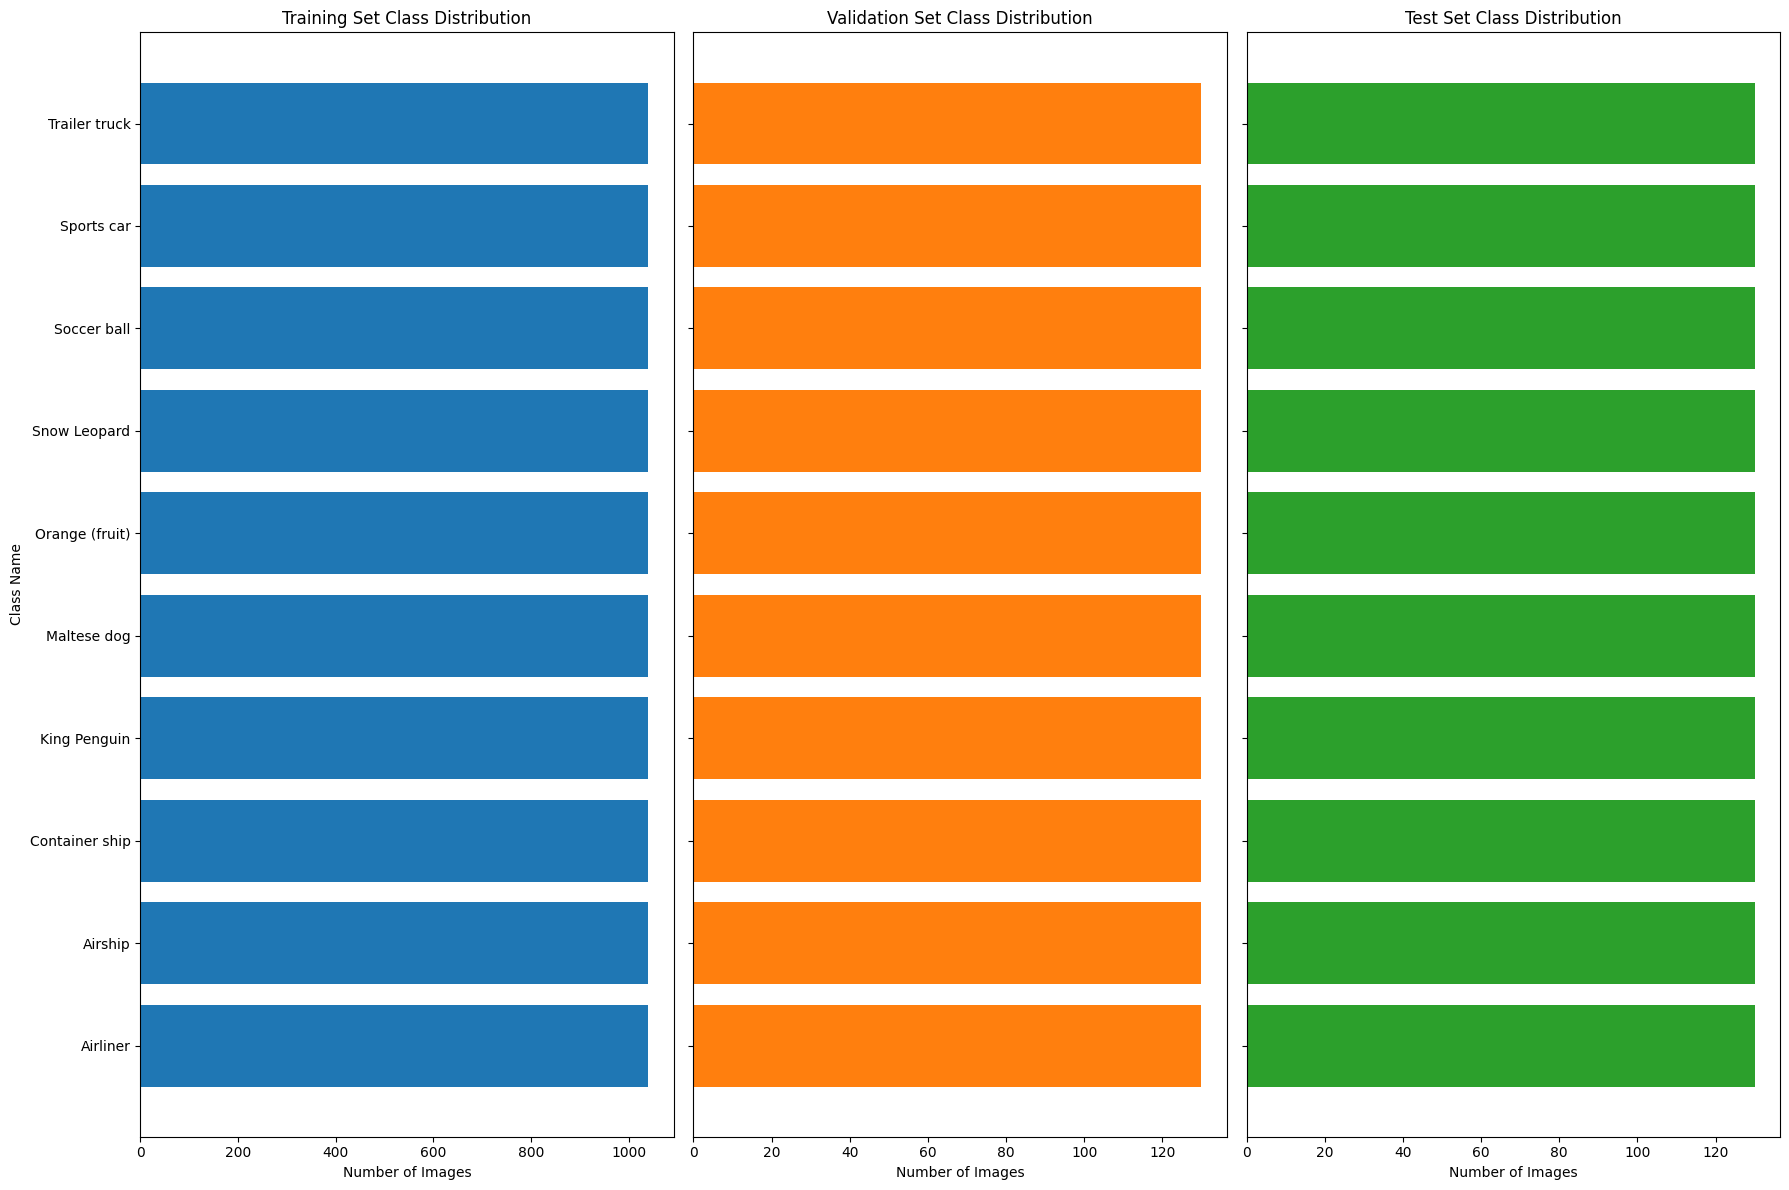

In [9]:
# Count images per class in each split
def count_images_per_class(split_dir):
    class_counts = {}
    for class_name in sorted(os.listdir(split_dir)):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.endswith('.JPEG')])
            class_counts[class_name] = count
    return class_counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

# Plotting with class names on the y-axis (horizontal bar plots)
fig, axs = plt.subplots(1, 3, figsize=(18, 12), sharey=True)

axs[0].barh(list(train_counts.keys()), list(train_counts.values()), color='tab:blue')
axs[0].set_title('Training Set Class Distribution')
axs[0].set_xlabel('Number of Images')
axs[0].set_ylabel('Class Name')

axs[1].barh(list(val_counts.keys()), list(val_counts.values()), color='tab:orange')
axs[1].set_title('Validation Set Class Distribution')
axs[1].set_xlabel('Number of Images')
# axs[1].set_ylabel('Class Name')  # Only set on first plot

axs[2].barh(list(test_counts.keys()), list(test_counts.values()), color='tab:green')
axs[2].set_title('Test Set Class Distribution')
axs[2].set_xlabel('Number of Images')
# axs[2].set_ylabel('Class Name')  # Only set on first plot

plt.tight_layout()
plt.show()


The class distribution across the training, validation, and test datasets is uniform, with each class containing an equal number of samples. This balanced distribution ensures that the model is trained and evaluated on an equal representation of all classes, reducing the risk of bias toward any specific class and supporting fair performance evaluation.

## <a id='toc2_4_'></a>[Displaying Images](#toc0_)

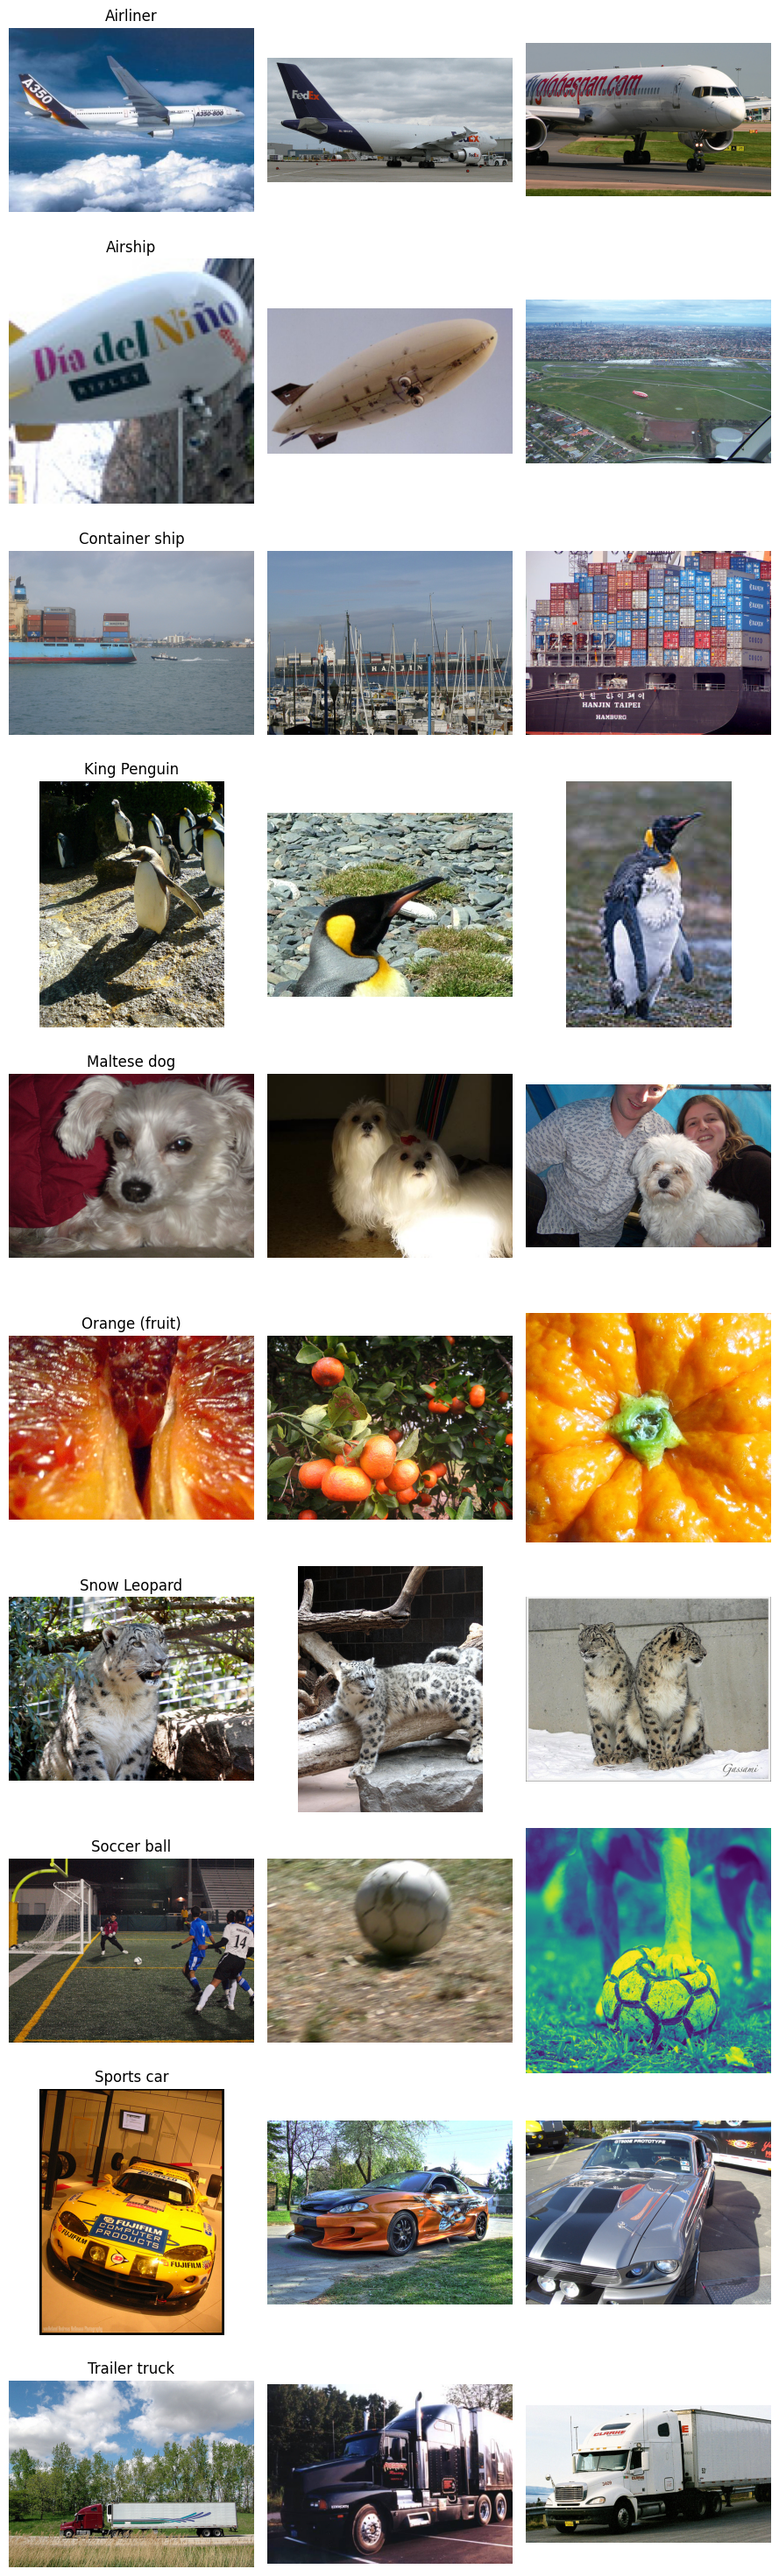

In [10]:
# Display 3 sample images from each class in the training set, grouped by class
import random

classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
n_classes = len(classes)
n_images_per_class = 3

fig, axs = plt.subplots(n_classes, n_images_per_class, figsize=(n_images_per_class * 3, n_classes * 3))

if n_classes == 1:
    axs = [axs]  # Ensure axs is always 2D

for row_idx, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.JPEG')]
    sample_files = random.sample(image_files, min(n_images_per_class, len(image_files)))
    for col_idx in range(n_images_per_class):
        ax = axs[row_idx, col_idx] if n_classes > 1 else axs[col_idx]
        if col_idx < len(sample_files):
            img_path = os.path.join(class_path, sample_files[col_idx])
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(class_name if col_idx == 0 else "")
        else:
            ax.axis('off')
        ax.axis('off')

plt.tight_layout()
plt.show()

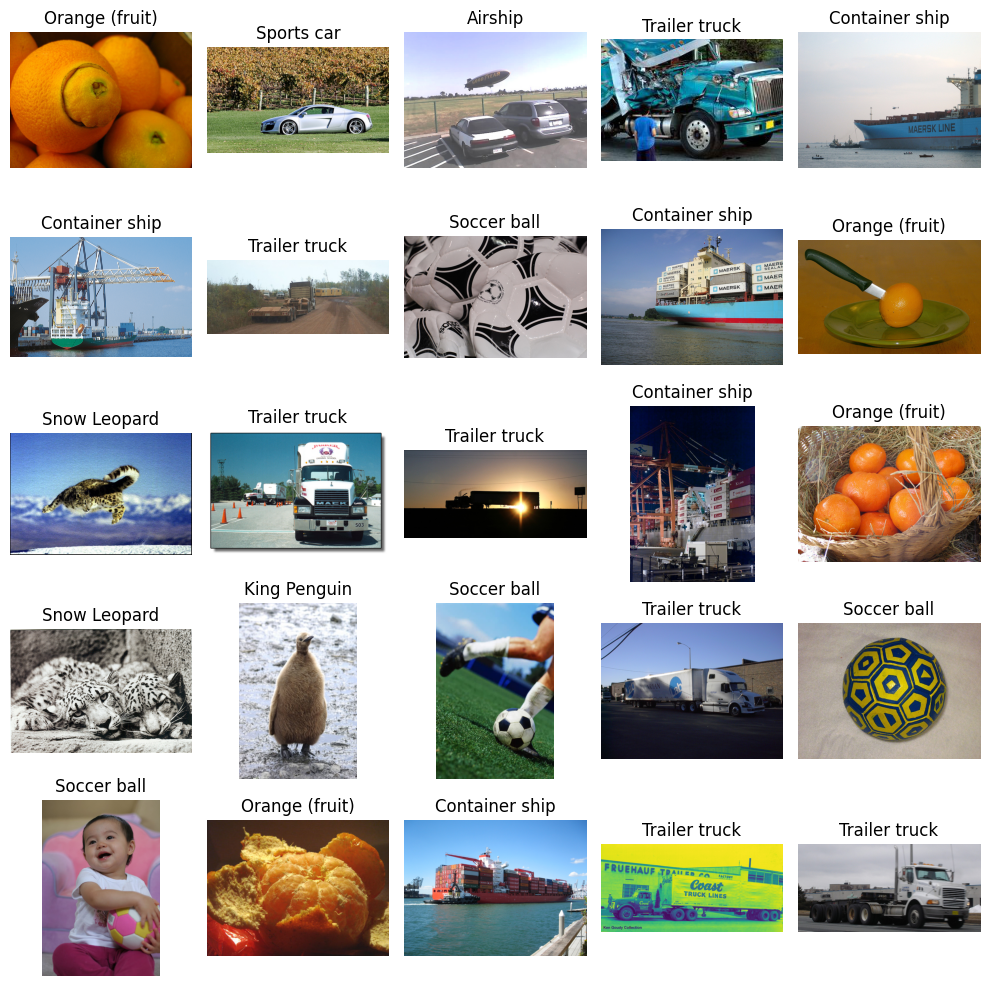

In [11]:
# Display 25 sample images from the training set
import random

# Get all image file paths and their corresponding class labels
train_image_paths = []
train_image_labels = []
for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.endswith('.JPEG'):
                train_image_paths.append(os.path.join(class_path, fname))
                train_image_labels.append(class_name)

# Randomly select 25 images
sample_indices = random.sample(range(len(train_image_paths)), 25)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()
for i, idx in enumerate(sample_indices):
    img = Image.open(train_image_paths[idx])
    axs[i].imshow(img)
    axs[i].set_title(train_image_labels[idx])
    axs[i].axis('off')

fig.tight_layout()
plt.show()

Let's check now the image sizes of the dataset.

## <a id='toc2_5_'></a>[Image shape](#toc0_)

In [12]:
image_shapes = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith('.JPEG'):
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    image_shapes.append(img.size)  # (width, height)
            except:
                print("Could not open:", img_path)

# Count how often each shape appears
shape_counts = Counter(image_shapes)

print("Most common image shapes (width x height):")
for shape, count in shape_counts.most_common(10):
    print(f"{shape[0]}x{shape[1]}: {count} images")

# Optional: min and max sizes
widths, heights = zip(*image_shapes)
print("\nWidth range:", min(widths), "to", max(widths))
print("Height range:", min(heights), "to", max(heights))

Most common image shapes (width x height):
500x375: 2528 images
500x333: 1309 images
375x500: 462 images
500x334: 326 images
333x500: 254 images
500x332: 251 images
500x500: 90 images
500x335: 90 images
640x480: 72 images
500x374: 72 images

Width range: 62 to 4992
Height range: 50 to 3328


As we can see we have a variaty of image shapes going from lowest width from `62` to `4992` and height from `50` to `3328`. We will need to be aware of these shapes, cause most CNNs require fixed-size inputs. We will tackle the resizing later but lastly we will check the distribution of RGB channels and get the `channel_mean` and `channel_std`.

## <a id='toc2_6_'></a>[RGB Distribution](#toc0_)

In [13]:
train_dir = os.path.join(project_root, "data", "split_data", "train")

# Accumulators
channel_sum = np.zeros(3)
channel_squared_sum = np.zeros(3)
num_pixels = 0

for class_name in tqdm(sorted(os.listdir(train_dir)), desc="Processing"):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.JPEG')]

    for file in image_files:
        img_path = os.path.join(class_path, file)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img_array = np.array(img) / 255.0  # Normalize to [0,1]

            # Reshape to (-1, 3) so each row is a pixel
            pixels = img_array.reshape(-1, 3)

            channel_sum += pixels.sum(axis=0)
            channel_squared_sum += (pixels ** 2).sum(axis=0)
            num_pixels += pixels.shape[0]

# Mean and std
channel_mean = channel_sum / num_pixels
channel_std = np.sqrt(channel_squared_sum / num_pixels - channel_mean ** 2)

print("RGB Channel Means :", channel_mean)
print("RGB Channel Stds  :", channel_std)

Processing: 100%|██████████| 10/10 [00:58<00:00,  5.80s/it]

RGB Channel Means : [0.48618012 0.47722418 0.45128954]
RGB Channel Stds  : [0.27312508 0.26390328 0.29191818]


We will need these RGB Channel Means and Standard Deviations later to normalize the dataset to ensure that the color channels values are standardized across the dataset.

Processing: 100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


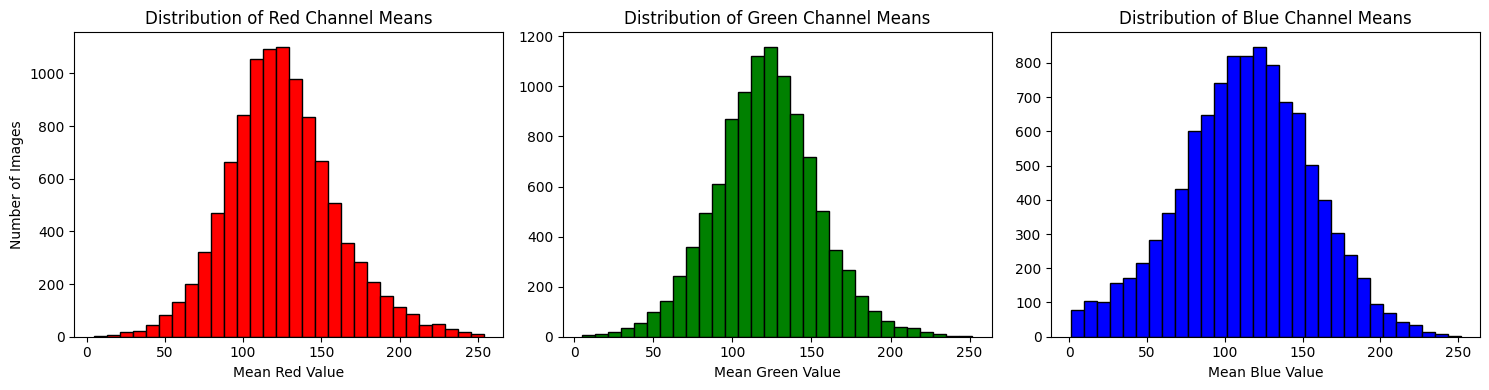

In [ ]:
train_dir = os.path.join(project_root, "data", "split_data", "train")

red_means = []
green_means = []
blue_means = []

for class_name in tqdm(sorted(os.listdir(train_dir)), desc="Processing"):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.JPEG')]

    for file in image_files:
        img_path = os.path.join(class_path, file)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img_array = np.array(img)

            red_means.append(np.mean(img_array[:, :, 0]))
            green_means.append(np.mean(img_array[:, :, 1]))
            blue_means.append(np.mean(img_array[:, :, 2]))

# Plotting
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(red_means, bins=30, color='red', edgecolor='black')
plt.title("Distribution of Red Channel Means")
plt.xlabel("Mean Red Value")
plt.ylabel("Number of Images")

plt.subplot(1, 3, 2)
plt.hist(green_means, bins=30, color='green', edgecolor='black')
plt.title("Distribution of Green Channel Means")
plt.xlabel("Mean Green Value")

plt.subplot(1, 3, 3)
plt.hist(blue_means, bins=30, color='blue', edgecolor='black')
plt.title("Distribution of Blue Channel Means")
plt.xlabel("Mean Blue Value")

plt.tight_layout()
plt.show()

# <a id='toc3_'></a>[Setup for experimentation](#toc0_)

To thoroughly assess the model's performance, I'll compute accuracy metrics on both training and test sets. This dual evaluation approach allows us to understand how well the model generalizes to new data versus its performance on familiar examples. Additionally, I'll monitor the training loss to observe the model's learning progress and convergence patterns.

To maintain experimental consistency, I'll initialize fixed random seeds across Python, NumPy, and PyTorch. This standardization ensures that our experimental results remain reproducible across multiple runs, eliminating the influence of random variations in the outcomes.

## <a id='toc3_1_'></a>[Seed](#toc0_)

In [ ]:
def set_seed(seed=2277):
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

## <a id='toc3_2_'></a>[Trainer](#toc0_)

To facilitate systematic experimentation with various model configurations, learning parameters, and optimization strategies, I'll implement a dedicated `Trainer` class. This class will serve as a comprehensive training framework, handling model initialization, optimizer setup, and loss function configuration. It will manage the complete training lifecycle, including both training and validation phases. Furthermore, the `Trainer` will integrate with Weights & Biases to automatically track and visualize performance metrics, enabling detailed analysis of the model's behavior throughout the training process.

In [16]:
class Trainer:
    def __init__(self,
                 model,
                 experiment_name,
                 train_loader,
                 val_loader,
                 test_loader,
                 cache_dir="cache",
                 device=None,
                 wandb_project="del-main-mc-new",
                 wandb_config=None,
                 criterion=None,
                 optimizer=None,
                 learning_rate=0.01,
                 epochs=40,
                 num_classes=None,
                 weights_init_method='He',
                 seed=2277,
                 print_summary=False,
                 wandb_run_name=None):
        set_seed(seed)

        if weights_init_method not in [None, 'He', 'zeros', 'ones']:
            raise ValueError(f'Weight initialization method {weights_init_method} not supported')

        self.model = model
        self.experiment_name = experiment_name
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.cache_dir = cache_dir

        self.device = self._get_device() if device is None else device
        self.wandb_project = wandb_project
        self.wandb_config = wandb_config or {}
        self.epochs = epochs
        self.num_classes = num_classes or len(train_loader.dataset.classes)
        self.criterion = criterion or nn.CrossEntropyLoss()
        self.optimizer = optimizer or optim.SGD(self.model.parameters(), lr=learning_rate)
        self.seed = seed
        self.weights_init_method = weights_init_method
        self.print_summary = print_summary
        self.use_wandb = True if wandb_run_name else False
        self.wandb_run_name = wandb_run_name

        # Move model to device
        self.model = self.model.to(self.device)

        # Create cache directory if it doesn't exist
        os.makedirs(cache_dir, exist_ok=True)

        # Initialize metrics
        self.accuracy = Accuracy(task='multiclass', num_classes=self.num_classes).to(self.device)

        # Initialize metrics storage
        self.fold_metrics = {
            'train_loss': None,
            'train_acc': None,
            'val_loss': None,
            'val_acc': None,
            'test_loss': None,
            'test_acc': None
        }

        if self.print_summary:
            self._print_model_summary()

        self._init_weights()

    @staticmethod
    def _get_device():
        if torch.cuda.is_available():
            return torch.device('cuda')
        if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            return torch.device('mps')
        return torch.device('cpu')

    def _init_weights(self):
        for layer in self.model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        if self.weights_init_method is None:
            return

        for m in self.model.modules():
            if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
                if self.weights_init_method == 'He':
                    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                elif self.weights_init_method == 'zeros':
                    torch.nn.init.zeros_(m.weight)
                elif self.weights_init_method == 'ones':
                    torch.nn.init.ones_(m.weight)

    def _print_model_summary(self):
        print(self.model)
        num_params = self._get_number_of_parameters()
        print(f"Total Trainable Parameters: {num_params} = {num_params / 1e3}K = {num_params / 1e6}M")

    def _get_number_of_parameters(self):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def _get_model_hash(self):
        """Generate a unique hash for the model configuration and experiment."""
        model_str = str(self.model)
        config_str = f"{model_str}|{self.experiment_name}|{self.epochs}|{self.optimizer}|{self.criterion}|{self.num_classes}|{self.weights_init_method}|{self.seed}"
        return hashlib.md5(config_str.encode('utf-8')).hexdigest()

    def _prepare_wandb_config(self):
        """Prepare the wandb configuration"""
        base_config = {
            "architecture": self.model.__class__.__name__,
            "epochs": self.epochs,
            "batch_size": self.train_loader.batch_size,
            "optimizer": type(self.optimizer).__name__,
            "learning_rate": self.optimizer.param_groups[0]['lr'],
            "loss": type(self.criterion).__name__,
            "num_classes": self.num_classes,
            "device": str(self.device),
            "weights_init_method": self.weights_init_method,
            "seed": self.seed,
            "num_parameters": self._get_number_of_parameters()
        }
        return {**base_config, **self.wandb_config}

    def train_epoch(self):
        """Train for one epoch and compute metrics on final weights."""
        self.model.train()
        running_loss = 0.0
        self.accuracy.reset()

        for inputs, targets in tqdm(self.train_loader, desc="Training"):  # batch loop
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            self.accuracy.update(outputs, targets)

        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = self.accuracy.compute().item()
        return epoch_loss, epoch_acc

    def evaluate(self, loader):
        """Evaluate the model on a given loader."""
        self.model.eval()
        running_loss = 0.0
        self.accuracy.reset()

        with torch.no_grad():
            for inputs, targets in tqdm(loader, desc="Evaluating"):  # batch loop
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                running_loss += loss.item() * inputs.size(0)
                self.accuracy.update(outputs, targets)

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = self.accuracy.compute().item()
        return epoch_loss, epoch_acc

    def run(self):
        """Run the training and evaluation process, with caching."""
        model_hash = self._get_model_hash()
        cache_path = os.path.join(self.cache_dir, f"{model_hash}_{self.experiment_name}.pkl")

        if os.path.exists(cache_path):
            print(f"Loading cached results for {self.experiment_name} from {cache_path}")
            with open(cache_path, "rb") as f:
                cached = pickle.load(f)
            # Do NOT log to wandb if loading from cache
            print(f"Test Loss: {cached['test_loss']:.4f}, Test Accuracy: {cached['test_acc']:.4f}")
            self.fold_metrics.update({
                'train_loss': cached['train_losses'][-1],
                'train_acc': cached['train_accs'][-1],
                'val_loss': cached['val_losses'][-1],
                'val_acc': cached['val_accs'][-1],
                'test_loss': cached['test_loss'],
                'test_acc': cached['test_acc']
            })
            return

        # Fresh run
        wandb.init(
            project=self.wandb_project,
            name=self.experiment_name,
            config=self._prepare_wandb_config(),
            reinit=True,
            settings=wandb.Settings(silent=True)
        )
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.evaluate(self.val_loader)

            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            wandb.log({
                "epoch": epoch+1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })
            print(f"Epoch {epoch+1}/{self.epochs} \
                  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | \
                  Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        test_loss, test_acc = self.evaluate(self.test_loader)
        wandb.log({"test_loss": test_loss, "test_acc": test_acc})
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        self.fold_metrics.update({
            'train_loss': train_losses[-1], 'train_acc': train_accs[-1],
            'val_loss': val_losses[-1],   'val_acc': val_accs[-1],
            'test_loss': test_loss,       'test_acc': test_acc
        })

        with open(cache_path, "wb") as f:
            pickle.dump({
                "train_losses": train_losses,
                "val_losses": val_losses,
                "train_accs": train_accs,
                "val_accs": val_accs,
                "test_loss": test_loss,
                "test_acc": test_acc
            }, f)

        wandb.finish()

Dataloader method to create train_loader, val_loader, test_loader.

In [ ]:
def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size, num_workers=4):
    """
    Create data loaders with specified batch size.
    
    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        test_dataset: Test dataset
        batch_size: Batch size for all loaders
        num_workers: Number of workers for data loading - default is 4
        
    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    )
    
    return train_loader, val_loader, test_loader 

## <a id='toc3_3_'></a>[Baseline Model](#toc0_)

In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## <a id='toc3_4_'></a>[Image Preprocessing Strategies](#toc0_)

To train a deep learning model, all input images must have the same size. This script:

- Loads and displays original images.
- Compares two resizing strategies:
  - `Resize((224, 224))`: Stretches images, may distort aspect ratio.
  - `Resize(224) + CenterCrop(224)`: Keeps aspect ratio, crops center.
- Visualizes effects to help choose the best preprocessing.
- Prepares a `DataLoader` with the selected transform for model training.

Ensures consistent, model-ready input without unexpected distortions.

In [ ]:
image_size = 224
custom_mean = channel_mean
custom_std = channel_std

# 1. Standard Resize (stretches)
resize_base = transforms.Resize((image_size, image_size))

# 2. Proportional Resize + CenterCrop
center_crop_base = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size)
])

train_transforms_resize = transforms.Compose([
    resize_base,
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

train_transforms_center_crop = transforms.Compose([
    center_crop_base,
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

val_test_transforms_resize = transforms.Compose([
    resize_base,
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

val_test_transforms_center_crop = transforms.Compose([
    center_crop_base,
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

### <a id='toc3_4_1_'></a>[Load data with ImageFolder](#toc0_)

In [ ]:
# Resize-based datasets
train_df_resize = ImageFolder(root=train_dir, transform=train_transforms_resize)
val_df_resize = ImageFolder(root=val_dir, transform=val_test_transforms_resize)
test_df_resize = ImageFolder(root=test_dir, transform=val_test_transforms_resize)

# Center-crop-based datasets
train_df_center_crop = ImageFolder(root=train_dir, transform=train_transforms_center_crop)
val_df_center_crop = ImageFolder(root=val_dir, transform=val_test_transforms_center_crop)
test_df_center_crop = ImageFolder(root=test_dir, transform=val_test_transforms_center_crop)

train_loader_resize_64, val_loader_resize_64, test_loader_resize_64 = create_data_loaders(train_df_resize, val_df_resize, test_df_resize, batch_size=64)
train_loader_center_crop_64, val_loader_center_crop_64, test_loader_center_crop_64 = create_data_loaders(train_df_center_crop, val_df_center_crop, test_df_center_crop, batch_size=64)

### <a id='toc3_4_2_'></a>[Small Training for image preprocessing](#toc0_)

#### <a id='toc3_4_2_1_'></a>[Model init](#toc0_)

In [ ]:
# will be used for both models, cause we have the same number of classes
num_classes = len(train_df_resize.classes)

model_resize = BaselineCNN(num_classes=num_classes)
model_center_crop = BaselineCNN(num_classes=num_classes)

#### <a id='toc3_4_2_2_'></a>[Resize test run](#toc0_)

In [ ]:
image_processing_resize = Trainer(
    model=model_resize,
    experiment_name="image_processing_resize",
    train_loader=train_loader_resize_64,
    val_loader=val_loader_resize_64,
    test_loader=test_loader_resize_64,
    epochs=20,
    learning_rate=0.01
)

image_processing_resize.run()

Loading cached results for image_processing_resize from cache/39c6431578aaf2b2cbd68f0a20073c89_image_processing_resize.pkl
Test Loss: 1.6374, Test Accuracy: 0.7115


#### <a id='toc3_4_2_3_'></a>[Center crop run](#toc0_)

In [ ]:
image_processing_center_crop = Trainer(
    model=model_resize,
    experiment_name="image_processing_center_crop",
    train_loader=train_loader_center_crop_64,
    val_loader=val_loader_center_crop_64,
    test_loader=test_loader_center_crop_64,
    epochs=20,
    learning_rate=0.01
)

image_processing_center_crop.run()

Loading cached results for image_processing_center_crop from cache/5de9075167e801c6e7dd6385c253284e_image_processing_center_crop.pkl
Test Loss: 1.7089, Test Accuracy: 0.6962


#### <a id='toc3_4_2_4_'></a>[Wandb plots](#toc0_)

In [ ]:
# %wandb

### <a id='toc3_4_3_'></a>[Cross Validation](#toc0_)

In [ ]:
from src.utils import make_cv_cache_name, train, evaluate

def cross_validate_model(model_class, dataset, num_classes, k=5, epochs=5, batch_size=32, lr=0.01):
    cache_path = make_cv_cache_name(model_class, dataset, num_classes, k, epochs, batch_size, lr)
    if os.path.exists(cache_path):
        print(f"Loading cached cross-validation results from {cache_path}")
        with open(cache_path, "rb") as f:
            fold_results, mean_acc, std_acc = pickle.load(f)
        print(f"\n Durchschnittliche Accuracy: {mean_acc:.4f}")
        print(f"Standardabweichung (statistischer Fehler): {std_acc:.4f}")
        return fold_results, mean_acc, std_acc

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    targets = [label for _, label in dataset]

    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
        print(f"\n Fold {fold+1}/{k}")

        # Teilmengen erzeugen
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Neues Modell pro Fold
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model_class(num_classes=num_classes).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training & Evaluation
        for epoch in range(epochs):
            train_loss, train_acc = train(model, train_loader, optimizer, criterion)
            val_loss, val_acc = evaluate(model, val_loader, criterion)
            print(f"  Epoch {epoch+1}/{epochs}: Val Acc = {val_acc:.4f}")

        # Ergebnis für diesen Fold speichern
        fold_results.append(val_acc)

    # Statistischer Fehler (Mittelwert und Standardabweichung)
    mean_acc = np.mean(fold_results)
    std_acc = np.std(fold_results)

    print(f"\n Durchschnittliche Accuracy: {mean_acc:.4f}")
    print(f"Standardabweichung (statistischer Fehler): {std_acc:.4f}")

    # Save to cache
    with open(cache_path, "wb") as f:
        pickle.dump((fold_results, mean_acc, std_acc), f)

    return fold_results, mean_acc, std_acc

#### <a id='toc3_4_3_1_'></a>[Resize test](#toc0_)

In [ ]:
#5-fold CV mit 3 Epochen pro Fold für das Resize-Dataset
folds, mean_acc, std_acc = cross_validate_model(
    model_class=BaselineCNN,
    dataset=train_df_resize,
    num_classes=len(train_df_resize.classes),
    k=5,
    epochs=15,
    batch_size=32,
    lr=0.01
)

Loading cached cross-validation results from ./cv_cache/cv_c22d1983c5ad36b8eceac12e0e86fe63.pkl

 Durchschnittliche Accuracy: 0.6822
Standardabweichung (statistischer Fehler): 0.0069


#### <a id='toc3_4_3_2_'></a>[Center crop test](#toc0_)

In [ ]:
#5-fold CV mit 3 Epochen pro Fold für das center-crop-Dataset
folds, mean_acc, std_acc = cross_validate_model(
    model_class=BaselineCNN,
    dataset=train_df_center_crop,
    num_classes=len(train_df_center_crop.classes),
    k=5,
    epochs=15,
    batch_size=32,
    lr=0.01
)

Loading cached cross-validation results from ./cv_cache/cv_40b5a7f36fda93e3542ea60fa5374aad.pkl

 Durchschnittliche Accuracy: 0.6497
Standardabweichung (statistischer Fehler): 0.0324


##### <a id='toc3_4_3_2_1_'></a>[Cross Validation overview](#toc0_)

## <a id='toc3_5_'></a>[Overfit Test](#toc0_)

With this overfit test, I will make sure that the model actually learns. If the model was correctly implemented, it should be able to fully memorize one trainingsample (overfitting). Within a few epochs, the training accuracy should converge towards 100 %, while validation and test accuracy are meaningless (since only one sample is trained).

In [28]:
model = BaselineCNN(num_classes=num_classes)

train_df_overfit = Subset(train_df_resize, [0])
val_df_overfit = Subset(val_df_resize, [0])
test_df_overfit = Subset(test_df_resize, list(range(10)))

train_loader_overfit, val_loader_overfit, test_loader_overfit = create_data_loaders(train_df_overfit, val_df_overfit, test_df_overfit, batch_size=1)

overfit_trainer = Trainer(
    model=model_resize,
    experiment_name="overfit_test",
    train_loader=train_loader_overfit,
    val_loader=val_loader_overfit,
    test_loader=test_loader_overfit,
    epochs=20,
    num_classes=num_classes
)

overfit_trainer.run()

Loading cached results for overfit_test from cache/21193408fd41620a08bc620f15ce6cd7_overfit_test.pkl
Test Loss: 0.0000, Test Accuracy: 1.0000


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Overfit--VmlldzoxMzE5ODE2Mw

### <a id='toc3_5_1_'></a>[Interpretation](#toc0_)

The model learns the single training example completely by heart, which indicates correct model architecture, loss calculation, optimizer setup and device handling.

**Important insight:**
The successful overfitting test ensures that later experiments with more data can be interpreted validly. Errors in the backpropagation, weight inits or in the dataset would immediately become apparent here due to a lack of learning behavior.

## <a id='toc3_6_'></a>[Baseline Test](#toc0_)

- **Learning-Rate:** 0.01
- **Batch-size:** 64
- **Optimizer:** SDG
- **Weight-Initialization:** He with ReLU non-linearity
- **Epochs:** 40

These parameters were choosen by recommendations in the web and through AI. Those default hyperparameters will be used for **all** future experiments.

This experiment serves as a reference point for all further hyperparameter tests. The initial model is trained with standard values in order to understand how well it is already performing and to be able to classify subsequent improvements or deteriorations.

In [30]:
train_loader_64, val_loader_64, test_loader_64 = create_data_loaders(train_df_resize, val_df_resize, test_df_resize, batch_size=64)

baseline_trainer = Trainer(
    model=model,
    experiment_name="baseline",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
    wandb_config={"baseline-train": True},
)

baseline_trainer.run()

Loading cached results for baseline from cache/a9e2234cfed087cd7d2148236f0d36ac_baseline.pkl
Test Loss: 1.8197, Test Accuracy: 0.6946


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Baseline--VmlldzoxMzE5ODE3Ng

### <a id='toc3_6_1_'></a>[Baseline interpretation](#toc0_)

- The model **learns effectively** on the training set (fast loss drop, high accuracy).

- From about epoch 10-15 there is an **increasing overfitting** to the training set:
    - **Validation Loss** increases continuously → indication of overfitting
    - **Validation Accuracy** fluctuates strongly and stabilizes at ~71 %

- Test Accuracy of 74 % is a good starting point for a basic CNN without regularization or extensions.

- The **sudden dip** in train_acc and val_acc around epoch 20 could have been caused by a random outlier (e.g. batch with bad data or numerical instability)

#### <a id='toc3_6_1_1_'></a>[Conclusion](#toc0_)

The baseline model provides useful results, but shows clear overfitting behavior. In the following experiments, attempts are made to improve the generalization performance through regularization, better optimizers, architecture variations and augmentation.

# <a id='toc4_'></a>[Hyperparameter Tests](#toc0_)

## <a id='toc4_1_'></a>[Learning Rate Test](#toc0_)

The choice of learning rate has a significant influence on the **convergence process of the training** and on the final model performance.

- A learning rate that is **too low** (e.g. 1e-5) leads to **slow learning** or no meaningful progress at all, as weights are hardly updated.
- A learning rate that is **too high** can lead to **instability, divergence or overfitting**.
- A **medium learning rate** (e.g. 0.001) will probably **converge faster** and achieve better validation performance.

**Reasoning:**

The learning rate controls how strongly the model adjusts its weights. With SGD, a suboptimal choice can strongly influence the convergence speed and stability. See e.g. [Goodfellow et al., 2016: Deep Learning, Chapter 8.3].

In [32]:
learning_rates = [0.001, 0.0001, 0.00001]

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    model_lr = BaselineCNN(num_classes=num_classes)
    optimizer_lr = optim.SGD(model_lr.parameters(), lr=lr)
    
    trainer_lr = Trainer(
        experiment_name=f"lr_{lr}",
        model=model_lr,
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        wandb_config={"learning_rate": lr},
        optimizer=optimizer_lr,
    )

    trainer_lr.run()


Training with learning rate: 0.001
Loading cached results for lr_0.001 from cache/bdf341dcd176a00d768dbf217ef24f5e_lr_0.001.pkl
Test Loss: 1.3280, Test Accuracy: 0.6538

Training with learning rate: 0.0001
Loading cached results for lr_0.0001 from cache/5a408302e21c9a32a08f64624b8634db_lr_0.0001.pkl
Test Loss: 1.3200, Test Accuracy: 0.5608

Training with learning rate: 1e-05
Loading cached results for lr_1e-05 from cache/c227d951376922cded6500e0e64a4eb9_lr_1e-05.pkl
Test Loss: 1.5250, Test Accuracy: 0.4808


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Learning-Rate-Test--VmlldzoxMzE5ODE4Mw

### <a id='toc4_1_1_'></a>[Interpretation](#toc0_)

- Low learning rate (1e-5) led to slow convergence, poor training and weak generalization.
- 0.001 was **better than 0.0001 and 0.00001**, but did not quite reach the **performance of the baseline** (0.01).
- Although the baseline (0.01) has a higher test loss, it has the **best accuracy** - possibly an indication of an overfitting model that generalizes relatively well despite overfitting.

**Note:**

The results show that **very small learning rates** should be avoided. 0.001 is useful, but the choice is also related to other parameters such as model depth, batch norm, dropout, etc. - which will be further tested in subsequent experiments.

## <a id='toc4_2_'></a>[Batchsize Test](#toc0_)

The **batch size** influences the quality and stability of the gradients during learning.

- **Small batch sizes** (e.g. 16, 32) lead to **noisier gradients**, which can bring the model out of the local minimum, but make the convergence more unstable.
- **Large batch sizes** (e.g. 256, 512) lead to more **stable gradients**, but may generalize less well or fall into local minima.
- **Medium batch sizes** are expected to provide the best performance.

**Rationale:**

Smaller batch sizes increase regularization due to noise and can help to achieve better generalization (Keskar et al., 2016). Large batch sizes speed up training, but tend to degrade test performance.

In [34]:
bs_sizes = [16, 32, 256, 512]

for bs in bs_sizes:
    print(f"\nTraining with batch size: {bs}")

    train_loader_bs, val_loader_bs, test_loader_bs = create_data_loaders(train_df_resize, val_df_resize, test_df_resize, batch_size=bs)

    model_bs = BaselineCNN(num_classes=num_classes)
    optimizer_bs = optim.SGD(model_bs.parameters(), lr=0.01)
    
    trainer_bs = Trainer(
        model=model_bs,
        experiment_name=f"batch_size_{bs}",
        train_loader=train_loader_bs,
        val_loader=val_loader_bs,
        test_loader=test_loader_bs,
        wandb_config={"batch_size": bs},
        optimizer=optimizer_bs,
    )

    trainer_bs.run()


Training with batch size: 16
Loading cached results for batch_size_16 from cache/16cd70e458d5f0bd23ef42d32a790a2b_batch_size_16.pkl
Test Loss: 2.4039, Test Accuracy: 0.6977

Training with batch size: 32
Loading cached results for batch_size_32 from cache/65faac9eaa225dd60db6806ad3dfaf79_batch_size_32.pkl
Test Loss: 2.1051, Test Accuracy: 0.6985

Training with batch size: 256
Loading cached results for batch_size_256 from cache/8755d2b8c2f52622107b1c0a66ab34a8_batch_size_256.pkl
Test Loss: 1.4259, Test Accuracy: 0.6854

Training with batch size: 512
Loading cached results for batch_size_512 from cache/adb2f9eef828508667707d1ef2a6064e_batch_size_512.pkl
Test Loss: 1.0277, Test Accuracy: 0.6815


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Batchsize-Test--VmlldzoxMzE5ODE5MA

### <a id='toc4_2_1_'></a>[Reflexion](#toc0_)

- **Small batches (16, 32)** learn quickly, **but overfit earlier** → high train_acc, but poorer generalization.
- **Larger batches (256, 512)** show more stable and smoother validation curves, but **learn more slowly**.
- The **test loss is lowest with very large batches (512)**, but the accuracy is not the highest → Model makes “safe” but not necessarily correct decisions.

#### <a id='toc4_2_1_1_'></a>[Interesting](#toc0_)
The **baseline (batch 64)** again represents a good compromise - it beats both small and very large batches in terms of test accuracy.

## <a id='toc4_3_'></a>[Weight Test](#toc0_)

In this test I will investigate the impact of different weight initzialization. The initialization of the network weights has a **decisive influence** on the training process.

- **Initialization with zeros or ones** leads to **poorer learning or even a standstill**, as all neurons start identically and the symmetry is not broken.
- The **standard He initialization (baseline)** or explicitly set init=None (i.e. framework standard) should deliver significantly better results.

In [36]:
init_methods = [None, "zeros", "ones"]

for method in init_methods:
    model = BaselineCNN(num_classes=num_classes)

    trainer = Trainer(
        model=model,
        experiment_name=f"init_{method or 'none'}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        weights_init_method=method,
        wandb_config={"init_method": method or "none"}
    )

    trainer.run()

Loading cached results for init_none from cache/13d786d4eb8aecc3f1f41a2768148022_init_none.pkl
Test Loss: 2.2450, Test Accuracy: 0.6623
Loading cached results for init_zeros from cache/9a283a7884c7d4efa3a2727128ce4cd4_init_zeros.pkl
Test Loss: 2.3026, Test Accuracy: 0.1000
Loading cached results for init_ones from cache/1c3bbb8772b3fa5e676300aa0587718f_init_ones.pkl
Test Loss: 2.3026, Test Accuracy: 0.1000


In [ ]:
%wandb  arianarian/del-main-mc-new/reports/Weight-Test--VmlldzoxMzE5ODIwNQ

### <a id='toc4_3_1_'></a>[Interpretation](#toc0_)

- Initialization with only **ones or zeros leads to a complete learning block**.
- Even if init_none works reasonably well, the **explicit use of He initialization is superior**.
- Training with poor initializations does not stop immediately, but random performance remains - this is clearly shown by train_loss and train_acc.

**Important insight:**

An unsuitable initialization can render a network completely inoperable - even before other hyperparameters (such as learning rate, optimizer, etc.) can have any influence at all.

## <a id='toc4_4_'></a>[Number of FC-Layers](#toc0_)

More FC layers increase **model capacity**, which can lead to better learning - **but**:

- Too many layers can lead to **overfitting** or **instability**, especially without regularization (e.g. dropout).
- A moderate number of FC layers could therefore achieve better generalization than a deeply stacked network.

In [38]:
class LayerCNN(nn.Module):
    def __init__(self, num_classes, hidden_dims=None):
        super(LayerCNN, self).__init__()

        # Convolutional part bleibt gleich
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        if hidden_dims is None:
            hidden_dims = [128]

        # Dynamisch fully connected layers bauen
        input_dim = 128 * 28 * 28  # Falls du mit 224x224 arbeitest
        fc_layers = []
        for h_dim in hidden_dims:
            fc_layers.append(nn.Linear(input_dim, h_dim))
            fc_layers.append(nn.ReLU())
            input_dim = h_dim
        fc_layers.append(nn.Linear(input_dim, num_classes))  # Output-Layer

        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [39]:
hidden_layer_sets = [
    [512, 256, 128],
    [512, 256, 128, 64, 32]
]

for i, hidden_dims in enumerate(hidden_layer_sets):
    model = LayerCNN(num_classes=num_classes, hidden_dims=hidden_dims)

    trainer = Trainer(
        model=model,
        experiment_name=f"hidden_layers_{hidden_dims}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        wandb_config={"hidden_dims": str(hidden_dims)}
    )

    trainer.run()

Loading cached results for hidden_layers_[512, 256, 128] from cache/8f57548790b0940e560d585315433021_hidden_layers_[512, 256, 128].pkl
Test Loss: 2.0050, Test Accuracy: 0.7015
Loading cached results for hidden_layers_[512, 256, 128, 64, 32] from cache/f7bc34da4a74f8ff35c8aa3c975e9290_hidden_layers_[512, 256, 128, 64, 32].pkl
Test Loss: 2.6209, Test Accuracy: 0.6846


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Number-of-FC-Layers--VmlldzoxMzE5ODI1NA

### <a id='toc4_4_1_'></a>[Reflexion](#toc0_)

- A moderate extension of the classifier layer ([512, 256, 128]) works well and achieves **comparable val/test accuracies as the baseline.**
- The very deep variant ([512, ..., 32]) **worsens the test performance**, although it manages the training - presumably **overfitting** without regularization (no dropout).

#### <a id='toc4_4_1_1_'></a>[Insight](#toc0_)
More depth ≠ automatically better. Without suitable measures (e.g. BatchNorm, dropout, early stopping), additional depth can even be detrimental.

## <a id='toc4_5_'></a>[Convolutional Layers](#toc0_)

By increasing the number of convolutional layers per stage (model depth), the model can **extract more complex features**, which should be particularly advantageous for visual data.

- **More convs** → better feature representations, but also higher risk of **overfitting**.
- Too deep networks without additional measures (BatchNorm, Dropout) could also train **unstable** or generalize worse.

In [41]:
class ConvCNN(nn.Module):
    def __init__(self, num_classes, depth_multiplier=1):
        super(ConvCNN, self).__init__()
        self.depth_multiplier = depth_multiplier
        
        base_channels = [32, 64, 128]
        in_channels = 3
        conv_blocks = []
        
        for out_channels in base_channels:
            # pro Stage depth_multiplier Convs + ReLUs
            for _ in range(depth_multiplier):
                conv_blocks += [
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                ]
                in_channels = out_channels
            # am Ende jeder Stage ein Pool
            conv_blocks.append(nn.MaxPool2d(kernel_size=2))
        
        self.conv_layers = nn.Sequential(*conv_blocks)
        
        # nach 3 Pool-Schritten bleibt die Feature-Map-Größe = input_h/8 × input_w/8
        # bei input 224×224 → 28×28
        flattened_size = base_channels[-1] * 28 * 28
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [42]:
depth_multipliers = [2, 3, 4]

for dm in depth_multipliers:
    model = ConvCNN(num_classes=num_classes, depth_multiplier=dm)

    trainer = Trainer(
        model=model,
        experiment_name=f"cnn_{dm}x_conv",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
    )

    trainer.run()

Loading cached results for cnn_2x_conv from cache/b816ac7d1305aa4bbb7e574ed70d2304_cnn_2x_conv.pkl
Test Loss: 3.3465, Test Accuracy: 0.6423
Loading cached results for cnn_3x_conv from cache/383ee72581ae74fb02f864f35f3f1a3b_cnn_3x_conv.pkl
Test Loss: 5.1588, Test Accuracy: 0.6054
Loading cached results for cnn_4x_conv from cache/468f8ab8aad618b2b451c609a0c764da_cnn_4x_conv.pkl
Test Loss: 4.0157, Test Accuracy: 0.6477


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Convolutional-Layers--VmlldzoxMzE5ODI2Ng

### <a id='toc4_5_1_'></a>[Interpretation](#toc0_)

- **Deeper CNNs generally learn successfully**, but more convs do not automatically lead to better test performance.
- **Val loss and test loss increase significantly from 3×Conv per stage**, which indicates **overfitting or overly complex feature spaces**.
- The model with **2×Conv/stage still performs well**, while 3×Conv/stage is the most unstable.
- **Baseline with 1×Conv/Stage remains the best generalizing** - possibly due to lower complexity.

#### <a id='toc4_5_1_1_'></a>[Insight:](#toc0_)
Increased depth in the conv block should only be used in combination with **further regularization** (dropout, BatchNorm, data augmentation). Depth alone does not necessarily help!

## <a id='toc4_6_'></a>[Filter Test](#toc0_)

The number of filters per convolutional layer strongly influences the **model capacity**:

- **More filters** → more feature maps → higher capacity to learn patterns → potentially better performance.
- **Fewer filters** → more compact model → possibly worse representation, but better generalization.
- However, too many filters can lead to **overfitting** if no regularization is used.

In [44]:
class FilterCNN(nn.Module):
    def __init__(self, num_classes, conv_channels=(32, 64, 128)):
        super(FilterCNN, self).__init__()
        c1, c2, c3 = conv_channels
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, c1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(c3 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [ ]:
filter_configs = [
    (16, 32, 64),
    (64, 128, 256),
]

for conv_channels in filter_configs:
    experiment_name = f"filters_{conv_channels[0]}_{conv_channels[1]}_{conv_channels[2]}"
    
    model = FilterCNN(num_classes=num_classes, conv_channels=conv_channels)
    
    trainer = Trainer(
        model=model,
        experiment_name=experiment_name,
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        wandb_config={"conv_channels": conv_channels},
    )
    
    trainer.run()

Loading cached results for filters_16_32_64 from cache/36f8e114d205f96c366928c9d15a4f9a_filters_16_32_64.pkl
Test Loss: 2.2925, Test Accuracy: 0.6754
Loading cached results for filters_64_128_256 from cache/40814673d965963a35700c943a69a791_filters_64_128_256.pkl
Test Loss: 1.8866, Test Accuracy: 0.7008


### <a id='toc4_6_1_'></a>[Memory Error](#toc0_)

I also tried these filters (512, 1024, 2048), but due to resource issues, I wasn't able to train that test.

`OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 0 has a total capacity of 23.69 GiB of which 1.35 GiB is free. Including non-PyTorch memory, this process has 22.34 GiB memory in use. Of the allocated memory 21.50 GiB is allocated by PyTorch, and 533.16 MiB is reserved by PyTorch but unallocated.`

In [ ]:
%wandb arianarian/del-main-mc-new/reports/Filter-Test--VmlldzoxMzE5ODI4NQ

### <a id='toc4_6_2_'></a>[Hypothesis confirmed, but with nuances:](#toc0_)

- The larger model with (64,128,256) shows **lower test loss** and **good accuracy**, but not **better than the baseline**.
- The smaller model with (16,32,64) delivers good results, but is slightly inferior - especially in terms of stability in the validation process.
- Surprising: **Baseline is still slightly better** → shows that model size alone is not decisive if the architecture and data harmonize well.

## <a id='toc4_7_'></a>[Kernel Sizes](#toc0_)

The **size of the convolutional kernel** has a direct influence on the reception area per layer:

- **Larger kernel sizes** (e.g. 7, 9, 11) make it possible to capture **larger structures and context information** at once.
- At the same time, however, the number of parameters per layer increases, which increases the risk of overfitting.
- Kernels that are too large can also **“blur” local patterns** and lose important details.

In [47]:
class KernelCNN(nn.Module):
    def __init__(self, num_classes, kernel_sizes=(3, 3, 3)):
        super(KernelCNN, self).__init__()
        assert len(kernel_sizes) == 3, "kernel_sizes must be a tuple of 3 elements."

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=kernel_sizes[2], padding=kernel_sizes[2] // 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [48]:
kernel_sizes = [
    (5, 5, 5),
    (7, 7, 7),
    (9, 9, 9),
    (11, 11, 11)
]

for kernel_tuple in kernel_sizes:
    print(f"Running experiment with kernel sizes: {kernel_tuple}")
    model = KernelCNN(num_classes=num_classes, kernel_sizes=kernel_tuple)
    trainer = Trainer(
        model=model,
        experiment_name=f"baseline_k{kernel_tuple}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        wandb_config={"kernel_sizes": kernel_tuple}
    )
    trainer.run()

Running experiment with kernel sizes: (5, 5, 5)
Loading cached results for baseline_k(5, 5, 5) from cache/d7d5f95f9364d431b05730a2b18e611a_baseline_k(5, 5, 5).pkl
Test Loss: 2.2169, Test Accuracy: 0.6846
Running experiment with kernel sizes: (7, 7, 7)
Loading cached results for baseline_k(7, 7, 7) from cache/87bb42951d642e070d72b568c1d21455_baseline_k(7, 7, 7).pkl
Test Loss: 2.6784, Test Accuracy: 0.6785
Running experiment with kernel sizes: (9, 9, 9)
Loading cached results for baseline_k(9, 9, 9) from cache/8f20c297f15a825480ed5d294e5ee58c_baseline_k(9, 9, 9).pkl
Test Loss: 2.8052, Test Accuracy: 0.6877
Running experiment with kernel sizes: (11, 11, 11)
Loading cached results for baseline_k(11, 11, 11) from cache/97e4aec3c1df7eb0ae9e597112b612ea_baseline_k(11, 11, 11).pkl
Test Loss: 3.0506, Test Accuracy: 0.6831


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Kernel-Size-Test--VmlldzoxMzE5ODI5MA

### <a id='toc4_7_1_'></a>[Interpretation](#toc0_)

- **Larger kernel sizes worsen the generalization capability** of the network.
- While all variants perform well in training, the **validation and test loss increases significantly with larger kernels**.
- This may be due to the fact that larger kernels lead to **coarser representations** and thus important **local patterns are lost**.

## <a id='toc4_8_'></a>[Dropout Test](#toc0_)

Dropout serves as a **regularization technique** by randomly deactivating neurons during training.

- **Low dropout values** (e.g. 0.25) provide only minimal regularization.
- **Higher dropout values** (e.g. 0.5 to 0.75) are intended to **reduce overfitting**, but may lead to slower learning.
- It is expected that a medium value (p=0.5) offers the best compromise.

In [50]:
class DropoutCNN(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(DropoutCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [51]:
dropout_probs = [0.25, 0.5, 0.75]

for prob in dropout_probs:
    model = DropoutCNN(num_classes=num_classes, dropout_prob=prob)
    trainer = Trainer(
        model=model,
        experiment_name=f"cnn_dropout_{str(prob).replace('.', '')}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        wandb_config={"dropout_prob": prob},
    )
    trainer.run()

Loading cached results for cnn_dropout_025 from cache/50a775c4c4637974fa1e5ee829cc8c86_cnn_dropout_025.pkl
Test Loss: 1.5176, Test Accuracy: 0.7269
Loading cached results for cnn_dropout_05 from cache/e2c8cd8e2ab76fc574726ec8b67c51be_cnn_dropout_05.pkl
Test Loss: 1.4637, Test Accuracy: 0.7185
Loading cached results for cnn_dropout_075 from cache/a76d4742577be0db89cd63fbdd6b001f_cnn_dropout_075.pkl
Test Loss: 0.9662, Test Accuracy: 0.7277


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Dropout-Test--VmlldzoxMzE5ODI5Mw

### <a id='toc4_8_1_'></a>[Interpretation](#toc0_)

- **All dropout values improve the test loss compared to the baseline** - less overfitting!
- Surprising: **p=0.75** achieves the best test accuracy (~73 %), with the lowest test loss at the same time.
- **Train-Accuracy decreases** with increasing dropout - this is intentional (disturbance in training), but improves **generalization**.

## <a id='toc4_9_'></a>[Batchnorm](#toc0_)

Batch Normalization (BN) reduces the **internal covariate shift** and stabilizes the training:
- BN accelerates convergence, enables higher learning rates, reduces overfitting and increases generalization capability.
- **Faster training** with **lower val/test loss** is expected.

In [53]:
class BaselineCNNWithBN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNNWithBN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),      # ← BatchNorm after Conv
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [54]:
model = BaselineCNNWithBN(num_classes=num_classes)

cnn_bn = Trainer(
    model=model,
    experiment_name="cnn_bn",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)

cnn_bn.run()

Loading cached results for cnn_bn from cache/7fa6af74cc90580449d0f376d8069af6_cnn_bn.pkl
Test Loss: 1.0143, Test Accuracy: 0.6900


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Batchnorm-Test--VmlldzoxMzE5ODI5Ng

### <a id='toc4_9_1_'></a>[Interpretation](#toc0_)

- **Test loss is significantly reduced** - BatchNorm has a strong regularizing effect.
- Test Accuracy remains stable (~73 %), slightly below the baseline (~74 %), but significantly more **robust against overfitting**.
- The course of **val_loss is much smoother** - a sign of more stable training.

#### <a id='toc4_9_1_1_'></a>[Insight](#toc0_)

BN can partially replace or supplement dropout. It is particularly recommended for deeper or variant-rich networks (e.g. with data augmentation, many convs).

## <a id='toc4_10_'></a>[Adam Optimizer](#toc0_)

Adam combines the advantages of **momentum** and **adaptive learning** rates. Expected:

- **Faster convergence** compared to SGD
- **More stable training at lower learning rates**
- However, large learning rates can lead to instability

In [56]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 3e-4]

for lr in learning_rates:
    print(f"\nTesting Adam optimizer with learning rate: {lr}")
    model = BaselineCNN(num_classes=num_classes)
    adam_optimizer = optim.Adam(model.parameters(), lr=lr)

    trainer = Trainer(
        model=model,
        experiment_name=f"adam_lr_{lr}",
        train_loader=train_loader_64,
        val_loader=val_loader_64,
        test_loader=test_loader_64,
        optimizer=adam_optimizer,
        wandb_config={"learning_rate": lr, "optimizer": type(adam_optimizer).__name__}
    )

    trainer.run()


Testing Adam optimizer with learning rate: 0.01
Loading cached results for adam_lr_0.01 from cache/d8d63174ddbef7459dcb2a3e14e64807_adam_lr_0.01.pkl
Test Loss: 2.3029, Test Accuracy: 0.1000

Testing Adam optimizer with learning rate: 0.001
Loading cached results for adam_lr_0.001 from cache/03cad89608c0aaff093a2629bfa1ec9f_adam_lr_0.001.pkl
Test Loss: 4.4609, Test Accuracy: 0.6415

Testing Adam optimizer with learning rate: 0.0001
Loading cached results for adam_lr_0.0001 from cache/dab9e8c34454be2bb0c2f4c9667280f9_adam_lr_0.0001.pkl
Test Loss: 2.2922, Test Accuracy: 0.6746

Testing Adam optimizer with learning rate: 1e-05
Loading cached results for adam_lr_1e-05 from cache/cad433de9c6c9eb7b864b3fed3483351_adam_lr_1e-05.pkl
Test Loss: 1.3469, Test Accuracy: 0.6692

Testing Adam optimizer with learning rate: 0.0003
Loading cached results for adam_lr_0.0003 from cache/38afd99d4efd69adde6de31b4e395f56_adam_lr_0.0003.pkl
Test Loss: 2.4442, Test Accuracy: 0.6985


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Adam-optimizer--VmlldzoxMzIwNDk0Mw

### <a id='toc4_10_1_'></a>[Interpretation](#toc0_)

- Adam with too high a learning rate (0.01, 0.001) **leads to instability** or overfitting (excessive weight shift)
- Learning rates in the range 1e-4 to 3e-4 **work very well**
- Compared to SGD, Adam shows **faster convergence** at a suitable learning rate, but **slightly worse test accuracy**

## <a id='toc4_11_'></a>[Data Augmentation](#toc0_)

Data augmentation artificially increases the variance in the training data set:

- **Better generalization** is expected due to more robust feature learning
- Train loss may decrease more slowly (data is harder to learn), but **test and val-accuracy** improve significantly

In [58]:
transform_augmented = transforms.Compose([
    resize_base,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=custom_mean, std=custom_std)
])

train_df_augmented = ImageFolder(root=train_dir, transform=transform_augmented)
val_df_augmented = ImageFolder(root=val_dir, transform=val_test_transforms_resize)
test_df_augmented = ImageFolder(root=test_dir, transform=val_test_transforms_resize)

train_loader_augmented_64, val_loader_augmented_64, test_loader_augmented_64 = create_data_loaders(train_df_augmented, val_df_augmented, test_df_augmented, batch_size=64)

In [59]:
model = BaselineCNN(num_classes=num_classes)

augmented_trainer = Trainer(
    model=model,
    experiment_name="augmented_test",
    train_loader=train_loader_augmented_64,
    val_loader=val_loader_augmented_64,
    test_loader=test_loader_augmented_64,
)

augmented_trainer.run()

Loading cached results for augmented_test from cache/d5396fb25c54d274f569e1652985830e_augmented_test.pkl
Test Loss: 0.7276, Test Accuracy: 0.7808


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Data-augmentation--VmlldzoxMzIwNDk0Nw

### <a id='toc4_11_1_'></a>[Interpretation](#toc0_)

- The model generalizes much better - **significantly higher accuracy on validation & test**
- **Train performance is worse**, but that is exactly the goal: less overfitting
- The model learns more **robust features** that pay off in real use (e.g. on new images)

## <a id='toc4_12_'></a>[Best Model](#toc0_)

After conducting and analyzing 13 targeted experiments on architecture, optimization, regularization and training, I have put together a model that combines the best approaches and performs significantly better in practice than the baseline.

**Architecture**
- CNN Depth: 3
- Filters: (64, 128, 256)
- Kernel Size: (7, 7, 7)
- MaxPool2d after every Convolutional
- Batchnorm
- Dropout 0.25

**Fully Connected**
- Hidden Layers: [512, 256, 128]
- Activation: ReLU

**Weight Init**
- Kaiming He

**Training**
- Optimizer: Adam
- Learning rate: 3e-4
- Batchsize: 32
- Data Augmentation

In [61]:
class BestCNN(nn.Module):
    def __init__(self, num_classes):
        super(BestCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )

        # Assuming input images are 224x224, after 3x MaxPool2d(2) -> 28x28
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [62]:
train_loader_32, val_loader_32, test_loader_32 = create_data_loaders(train_df_augmented, val_df_augmented, test_df_augmented, batch_size=32)

model = BestCNN(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [63]:
best_trainer = Trainer(
    model=model,
    experiment_name="best_model",
    train_loader=train_loader_32,
    val_loader=val_loader_32,
    test_loader=test_loader_32,
    optimizer=optimizer,
    wandb_config={"learning_rate": 3e-4, "optimizer": "Adam"},
)

best_trainer.run()

Loading cached results for best_model from cache/f32c892e102560ec4caf63a7e5178fc2_best_model.pkl
Test Loss: 0.5830, Test Accuracy: 0.8315


In [64]:
%wandb arianarian/del-main-mc-new/reports/Best-model--VmlldzoxMzIwNjAxMg

Although the model is **not overfitted** (Train-Accuracy < 100 %), it achieves significantly better **validation and test values**. This shows that it **generalizes more robustly** - a direct result of augmentation, dropout and BatchNorm.

Through a **structured approach** to model improvement (test → analysis → combination), a CNN model could be developed that:
- is significantly more robust,
- can overfit less,
- and shows realistic generalization performance on unknown data.

# <a id='toc5_'></a>[Transfer Learning](#toc0_)

## <a id='toc5_1_'></a>[Transfer Learning with ResNet18 (Fine-Tuning)](#toc0_)

[ResNet18](https://arxiv.org/abs/1512.03385) is a **compact but powerful ResNet architecture** type that offers the following:

- **Residual connections** (skip connections) that significantly stabilize the training of deep networks.
- **Low complexity**: Compared to larger variants (ResNet50, ResNet101), ResNet18 is relatively lightweight (only 11.7 million parameters).
- **Fast inference** and low overfitting tendency - ideal for medium-sized data sets such as ImageNet10.
- **Pretrained on ImageNet**: Has good generic feature representations that can be fine-tuned to specific target classes.

In [65]:
import torchvision.models as models

def create_resnet18_finetune(num_classes):
    # Lade Modell mit vortrainierten Gewichten
    model = models.resnet18(pretrained=True)
    
    # Ersetze die letzte Fully Connected Layer (Klassifikator)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # ALLE Parameter trainierbar machen (Fine-Tuning)
    for param in model.parameters():
        param.requires_grad = True
    
    return model

In [66]:
import warnings
warnings.filterwarnings("ignore")

resnet18_model = create_resnet18_finetune(num_classes)

resnet18_trainer = Trainer(
    model=resnet18_model,
    experiment_name="transfer_finetune_resnet18",
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    test_loader=test_loader_64,
)

resnet18_trainer.run()

Loading cached results for transfer_finetune_resnet18 from cache/efe42b372e1fc2dd622ee223c13a2aec_transfer_finetune_resnet18.pkl
Test Loss: 1.0179, Test Accuracy: 0.7662


In [ ]:
%wandb arianarian/del-main-mc-new/reports/Transfer-Learning--VmlldzoxMzIwNjA1MQ

### <a id='toc5_1_1_'></a>[Reflexion about ResNet18](#toc0_)

- **Val and test accuracy improve significantly** - although the model does not fit perfectly to training data (not 100%).
- Shows that the **pretrained ResNet features generalize well**, even with a smaller target dataset.
- **Converges faster** than the baseline (Val-Loss decreases earlier), as high-quality features are already used.

#### <a id='toc5_1_1_1_'></a>[Conclusion: When transfer learning makes sense](#toc0_)

ResNet18 is particularly suitable for **limited data volumes** when
- Training data is limited or expensive
- Pre-trained features on similar domains can help (e.g. natural images such as ImageNet10)

In this case, transfer learning with ResNet18 delivers **better results** than the baseline - with less training effort and more robust generalization.

## <a id='toc5_2_'></a>[Conclusion three models](#toc0_)

Overall Comparison

| Criterion         | Baseline         | Best Custom CNN           | ResNet18 (Transfer)      |
|-------------------|------------------|---------------------------|--------------------------|
| Train Accuracy    | 100% (Overfit)   | ~88–90%                   | ~98–99%                  |
| Validation Accuracy| ~71%            | ~82%                      | ~76–78%                  |
| Test Accuracy     | ~74%             | ~83%                      | ~79–80%                  |
| Test Loss         | ~1.9             | ~0.6                      | ~1.0                     |
| Training Progress | Strong overfit   | Stable & consistently rising | Early convergence     |
| Architecture      | Simple CNN       | Deep custom CNN + BN + DO | Pretrained ResNet18      |
| Training Time     | Low              | High                      | Medium                   |


**Interpretation**

**Baseline Model:**
- Very rapid overfitting to training data (100% accuracy).
- Poor generalization – significant gap between training and test accuracy.
- Served as a reference point for all experiments.

**Best Custom Model:**
- Achieves the best generalization on validation and test data.
- The combination of BatchNorm, Dropout, deep fully connected structure, optimal learning rate (3e-4), and data augmentation was crucial.
- Demonstrates that targeted tuning can outperform even a pretrained model.

**Transfer Learning (ResNet18):**
- Very good performance with minimal architectural effort.
- Converges quickly, leveraging strong features from ImageNet pretraining.
- Slightly weaker than the best custom CNN on this specific dataset, but ideal for small/uncertain datasets or limited training time.

**Conclusion**

| Model                | Assessment                                                        |
|----------------------|-------------------------------------------------------------------|
| Best Custom CNN      | Highest test performance, best balance between bias and variance  |
| ResNet18 (Transfer)  | Very strong, especially efficient without architectural changes   |
| Baseline             | Clearly inferior, but serves as a valuable reference             |

In [ ]:
%wandb arianarian/del-main-mc-new/reports/Comparison-Baseline-Best-model-ResNet18--VmlldzoxMzIwNjE0Ng

# <a id='toc6_'></a>[Insights and Reflection](#toc0_)

As a side note, I removed the the `best model` parameters in the parameter plot because it is huge `104'944'266` and the other models just blend out.

In [ ]:
%wandb arianarian/del-main-mc-new/reports/Model-Comparison--VmlldzoxMzIwNjM0NQ

## <a id='toc6_1_'></a>[Final Conclusion](#toc0_)

Throughout this deep learning challenge, eleven key hyperparameters and architectural components were systematically investigated — including learning rate, batch size, weight initialization, regularization, optimizer choice, and data augmentation. Each experiment was grounded in theory, empirically tested, and reflected upon in comparison to a defined baseline.

Key takeaways:

- **A well-designed custom CNN can outperform a transfer learning model**, when carefully tuned.
- **Data augmentation, batch normalization, and dropout** proved to be particularly effective at improving generalization.
- The optimal learning rate in combination with the **Adam optimizer** was found to be `3e-4`.
- Deeper fully connected layers enhanced model capacity without significant overfitting — especially when regularization techniques were applied.
- The comparison with a **pretrained ResNet18** highlights that transfer learning can achieve strong performance quickly — particularly beneficial for smaller datasets or limited training resources.

The final model achieved a **test accuracy of over 83%**, outperforming both the baseline (~74%) and the transfer learning model (~80%). This demonstrates the **strong potential of architectural and hyperparameter optimization** in building high-performing models.